# 14. 심층 신경망(DNN)과 최적화(Optimization)

## 1. 딥러닝 학습의 문제점과 해결방법

### 1-1. 기울기 소실(Gradient Vanishing)
- 더 깊고 더 넓은 망을 학습시키는 과정에서 Output 값과 멀어질 수록 학습이 잘 안되는 현상
- 2006년, 힌튼이 “Wrong type of non-singularity”를 사용하고 있었다며 Sigmoid 함수 대신 ReLU(Rectified Linear Unit)을 사용할 것을 제안
- 내부 hidden layer에는 ReLU를 적용하고, output layer에서만 Tanh 함수를 적용하면 정확도가 훨씬 올라감

### 1-2. 가중치 초기화
- Bias는 0으로 초기화 하는 것이 일반적으로 효율적
- 가중치 초기화는 매우 중요함
- Sigmoid, tanh의 경우 Xavier 초기화 방법이 효율적
- ReLU계의 활성화 함수 사용 시 Xavier 초기화보다는 He 초기화 방법이 효율적 
- 최근의 대부분의 모델에서는 He초기화를 주로 선택(ReLU 많이 쓰니까)

#### Xavier 초기화 방법(2010) 
- 표준 정규 분포를 입력 개수의 제곱근으로 나누어 줌

---
w = np.random.randn(n_input, n_output) / sqrt(n_input)

----

-  Sigmoid와 같은 S자 함수의 경우 출력값들이 정규 분포 형태를 가져야 안정적으로 학습 가능 
- Sigmoid 함수와 Xavier 초기화 방법을 사용했을 경우의 그래프
- ReLU 함수에는 Xavier 초기화가 부적합(ReLU 함수와 Xavier 초기화 방법을 사용했을 경우의 그래프 레이어를 거쳐갈수록 값이 0에 수렴)

#### He 초기화 방법(2015)
-  표준 정규 분포를 입력 개수 절반의 제곱근으로 나누어 줌

---
w=np.random.randn(n_input, n_output) / sqrt(n_input / 2)

---
- ReLU 함수와 He 초기화 방법을 사용했을 경우의 그래프. 10층 레이어에서도 평균과 표준편차가 0 으로 수렴하지 않음

## 2. 최적화(Optimization) 알고리즘

### 2-1. 학습 알고리즘의 종류 
- GD(Gradient Descent) 
- SGD(Stochastic Gradient Descent) 
- Momentum
- AdaGrad
- RMSProp
- Adam

### SGD(Stochastic Gradient Descent) 
Gradient descent 알고리즘은 시작 지점에서 기울기의 반대방향으로 하강하면서 loss function을 최소화 된 지점을 찾기 위한 가장 직관적인 방법. 전체 데이터 셋을 가지고 학습 하게 되면 안정적이긴 하지만, 계산량과 학습 비용이 많아지게 된다.
이 때, 전체 data set이 아닌, **data를 sampling해서 gradient descent를 진행하고, 이를 반복하며 정확도를 찾아나가는 것을 Stochastic Graident Descent**라고 한다. 

---
**Stochastic Gradient Descent with nestrov**

 •optimizers.SGD(lr, momentum, nestrov) :  
 
     •lr : learning rate (lr >= 0)
     •momentum : 진동을 막아주고 SGD를 가속화하는 파라메터(momentum >= 0)
     •nesterov : 미분 지점을 유연하게 변경하도록 돕는 파라메터(nesterov = True / False)
  
  
Refecence : https://keras.io/optimizers/


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 128)               12928     
_________________________________________________________________
dense_19 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 129       
Total params: 29,569
Trainable params: 29,569
Non-trainable params: 0
_________________________________________________________________
Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 - 1s - loss: 0.7007 - accuracy: 0.5265 - binary_crossentropy: 0.7007 - val_loss: 0.6842 - val_accuracy: 0.5518 - val_binary_crossentropy: 0.6842
Epoch 2/20
25000/25000 - 0s - loss: 0.6812 - accuracy: 0.5677 - binary_crossentropy: 0.6812 - val_loss: 0.6774 - val_accuracy: 0.5769 - val_binary_crossentropy: 0

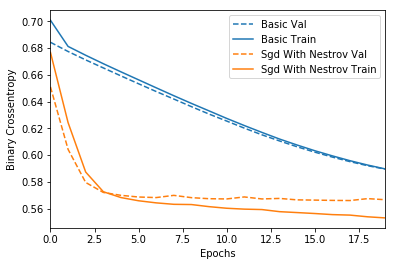

In [4]:
# [SGD(Stochastic Gradient Descent)]
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import optimizers

# 각각 리뷰에 따른 데이터 길이가 다르기 때문에 데이터의 Shape을 맞춰줘야합니다.
def sequences_shaping(sequences, dimension):
    # 0으로 채워진 (len(sequences), dimension) 크기의 행렬을 만듭니다
    results = np.zeros((len(sequences), dimension))
    for i, word_indices in enumerate(sequences):
        results[i, word_indices] = 1.0  # 각 리뷰 별 빈도수가 높은 단어를 dimension 개수 만큼만 추출하여 사용합니다.
        
    return results

# 시각화 함수
def Visulaize(histories, key='binary_crossentropy'):
    #plt.figure(figsize=(,20))

    for name, history in histories:
        val = plt.plot(history.epoch, history.history['val_'+key],
                   '--', label=name.title()+' Val')
        plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
             label=name.title()+' Train')

    plt.xlabel('Epochs')
    plt.ylabel(key.replace('_',' ').title())
    plt.legend()

    plt.xlim([0,max(history.epoch)])

# 100번째 까지 많이 사용하는 단어까지 추출
word_num = 100
data_num = 25000

# Keras에 내장되어 있는 imdb 데이터 세트를 불러옵니다.
# IMDb 데이터 세트는 Train 25000개 test 25000개로 이루어져 있습니다.
(train_data, train_labels), (test_data, test_labels) = keras.datasets.imdb.load_data(num_words=word_num)

# 데이터 Shape을 맞춰주기 위한 sequence 함수를 불러옵니다.
train_data = sequences_shaping(train_data, dimension=word_num)
test_data = sequences_shaping(test_data, dimension=word_num)

# Optimizer 모델와 비교하기 위해 기본 모델을 하나 만들어줍니다.
basic_model = keras.Sequential([
    # `.summary` 메서드 때문에 `input_shape`가 필요합니다
    # 첫 번째 Layer에 데이터를 넣을때는 input_shape을 맞춰줘야합니다.
    keras.layers.Dense(128, activation=tf.nn.relu, input_shape=(word_num,)),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

# Optimizer를 적용할 모델을 생성합니다.
optimizer_model = keras.Sequential([
    keras.layers.Dense(128, activation=tf.nn.relu, input_shape=(word_num,)),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

# 기존 모델을 학습시킬 최적화 방법, loss 계산 방법, 평가 방법을 설정합니다.
basic_model.compile(optimizer='sgd',
                    loss='binary_crossentropy',
                    metrics=['accuracy', 'binary_crossentropy'])

# 현재 모델이 어떻게 이루어져있는지 출력합니다.
basic_model.summary()

# 모델을 학습시킵니다.
basic_history = basic_model.fit(train_data,train_labels,epochs=20,batch_size=500,validation_data=(test_data, test_labels), verbose=2)

optimizer_model.compile(optimizer=optimizers.SGD(lr=0.01,momentum=0.9,nesterov=True),
                        loss='binary_crossentropy',
                        metrics=['accuracy', 'binary_crossentropy'])

# Optimization 모델이 어떻게 이루어져있는지 출력합니다.
optimizer_model.summary()
# Optimization 모델을 학습시킵니다.
optimizer_history = optimizer_model.fit(train_data, train_labels, epochs=20, batch_size=500, validation_data=(test_data, test_labels),verbose=2)


# 각 모델 별 Loss 그래프를 그려줍니다.
Visulaize([('Basic', basic_history),('SGD with nestrov', optimizer_history)])
              

---

### Adagrad optimizer
Adagrad는 loss function에서 최소값을 가지는 최적의 파라메터 W(weights; 가중치)를 찾아내기 위해 step size를 조절해 하강하는 방법 중 하나이다.
<br>
기존에 방식이 파라메터들의 학습속도를 같은 속도로 한꺼번에 갱신하는 방법이었다면, Adagrad는 파라메터 각각의 학습 속도를 데이터에 맞추어(adaptively) 계산하여 적절한 step size로 하강하도록 한다.
<br>
실제로 Adagrad를 적용하면 높은 그라디언트값을 갖는 파라메터(weight)들은 점점 학습속도가 감소하게 되고, 그라디언트 값이 낮거나 업데이트가 거의 없는 파라메터들은 실질 학습속도가 증가하게 된다. 이를 통해 최소값에 대한 효율적인 탐색이 가능해진다.

--- 
**Adagrad optimizer**

 •optimizers.Adagrad(lr, epsilon, decay) :  
 
    •lr : learning rate (lr >= 0)
    •epsilon : 연산 시 분모가 0이 되는 것을 막는 0에 가까운 상수(epsilon >= 0; None = default K.epsilon())
    •decay : 각 업데이트 시 learning rate를 비율 만큼 줄여 주는 파라메터(decay >= 0)

Refecence : https://keras.io/optimizers/


Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 128)               12928     
_________________________________________________________________
dense_25 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 129       
Total params: 29,569
Trainable params: 29,569
Non-trainable params: 0
_________________________________________________________________
Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 - 1s - loss: 0.6861 - accuracy: 0.5485 - binary_crossentropy: 0.6861 - val_loss: 0.6824 - val_accuracy: 0.5600 - val_binary_crossentropy: 0.6824
Epoch 2/20
25000/25000 - 1s - loss: 0.6782 - accuracy: 0.5744 - binary_crossentropy: 0.6782 - val_loss: 0.6752 - val_accuracy: 0.5828 - val_binary_crossentropy: 0

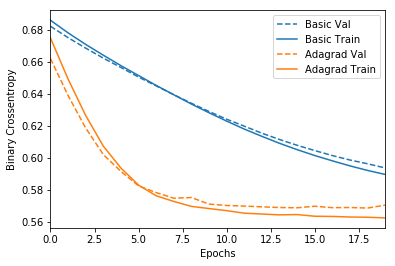

In [5]:
# [Adagrad optimizer]

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import optimizers

# 각각 리뷰에 따른 데이터 길이가 다르기 때문에 데이터의 Shape을 맞춰줘야합니다.
def sequences_shaping(sequences, dimension):
    # 0으로 채워진 (len(sequences), dimension) 크기의 행렬을 만듭니다
    results = np.zeros((len(sequences), dimension))
    for i, word_indices in enumerate(sequences):
        results[i, word_indices] = 1.0  # 각 리뷰 별 빈도수가 높은 단어를 dimension 개수 만큼만 추출하여 사용합니다.
        
    return results

# 시각화 함수
def Visulaize(histories, key='binary_crossentropy'):
    #plt.figure(figsize=(,20))

    for name, history in histories:
        val = plt.plot(history.epoch, history.history['val_'+key],
                   '--', label=name.title()+' Val')
        plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
             label=name.title()+' Train')

    plt.xlabel('Epochs')
    plt.ylabel(key.replace('_',' ').title())
    plt.legend()

    plt.xlim([0,max(history.epoch)])

# 100번째 까지 많이 사용하는 단어까지 추출
word_num = 100
data_num = 25000

# Keras에 내장되어 있는 imdb 데이터 세트를 불러옵니다.
# IMDb 데이터 세트는 Train 25000개 test 25000개로 이루어져 있습니다.
(train_data, train_labels), (test_data, test_labels) = keras.datasets.imdb.load_data(num_words=word_num)

# 데이터 Shape을 맞춰주기 위한 sequence 함수를 불러옵니다.
train_data = sequences_shaping(train_data, dimension=word_num)
test_data = sequences_shaping(test_data, dimension=word_num)

# Optimizer 모델와 비교하기 위해 기본 모델을 하나 만들어줍니다.
basic_model = keras.Sequential([
    # `.summary` 메서드 때문에 `input_shape`가 필요합니다
    # 첫 번째 Layer에 데이터를 넣을때는 input_shape을 맞춰줘야합니다.
    keras.layers.Dense(128, activation=tf.nn.relu, input_shape=(word_num,)),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

# Optimizer를 적용할 모델을 생성합니다.
optimizer_model = keras.Sequential([
    keras.layers.Dense(128, activation=tf.nn.relu, input_shape=(word_num,)),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

# 기존 모델을 학습시킬 최적화 방법, loss 계산 방법, 평가 방법을 설정합니다.
basic_model.compile(optimizer='sgd',
                    loss='binary_crossentropy',
                    metrics=['accuracy', 'binary_crossentropy'])
# 현재 모델이 어떻게 이루어져있는지 출력합니다.
basic_model.summary()
# 모델을 학습시킵니다.
basic_history = basic_model.fit(train_data,train_labels,epochs=20,batch_size=500,validation_data=(test_data, test_labels), verbose=2)

optimizer_model.compile(optimizer=optimizers.Adagrad(lr=0.0141, epsilon=None, decay=0.0),
                        loss='binary_crossentropy',
                        metrics=['accuracy', 'binary_crossentropy'])
# Optimization 모델이 어떻게 이루어져있는지 출력합니다.
optimizer_model.summary()
# Optimization 모델을 학습시킵니다.
optimizer_history = optimizer_model.fit(train_data, train_labels, epochs=20, batch_size=500, validation_data=(test_data, test_labels),verbose=2)


# 각 모델 별 Loss 그래프를 그려줍니다.
Visulaize([('Basic', basic_history),('Adagrad', optimizer_history)])
              

---

### Adadelta optimizer
Adadelta(Adaptive Delta) 는 Adagrad의 단점을 보완하기 위해 만들어진 방법.
 
보통 adagrad에서는 0.01 정도를 learning rate로 지정하게 되면, 다른 설정값(hyper-parameter) 없이 학습이 잘 진행됩니다. 따라서 설정값 여러 개에 크게 의존하지 않는다는 장점이 있다 . 하지만, 학습이 오래 진행될 경우 step size가 너무 작아져서 결국 거의 움직이지 않게 된다.
 
Adadelta는 2차 최적화(2nd order optimization) 기법을 따와서 학습 진행에 따라 0에 가까워지는 step size를 조절해 나갈 수 있도록 개선된 알고리즘.
 
---  
**Adadelta optimizer**
 •optimizers.Adadelta(lr, rho, epsilon, decay) :  
 
     •lr : 초기 learning rate (lr >= 0)
     •rho : Adadelta decay factor (rho >= 0)
     •epsilon : 연산 시 분모가 0이 되는 것을 막는 0에 가까운 상수(epsilon >= 0; None = default K.epsilon())
     •decay : 각 업데이트 시 learning rate를 비율 만큼 줄여 주는 파라메터(decay >= 0)
 
Refecence : https://keras.io/optimizers/

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 128)               12928     
_________________________________________________________________
dense_31 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 129       
Total params: 29,569
Trainable params: 29,569
Non-trainable params: 0
_________________________________________________________________
Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 - 1s - loss: 0.7074 - accuracy: 0.4827 - binary_crossentropy: 0.7074 - val_loss: 0.7026 - val_accuracy: 0.4894 - val_binary_crossentropy: 0.7026
Epoch 2/20
25000/25000 - 0s - loss: 0.6971 - accuracy: 0.5087 - binary_crossentropy: 0.6971 - val_loss: 0.6943 - val_accuracy: 0.5168 - val_binary_crossentropy: 

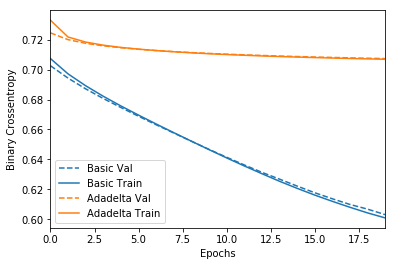

In [6]:
#[Adadelta optimizer]
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import optimizers

# 각각 리뷰에 따른 데이터 길이가 다르기 때문에 데이터의 Shape을 맞춰줘야합니다.
def sequences_shaping(sequences, dimension):
    # 0으로 채워진 (len(sequences), dimension) 크기의 행렬을 만듭니다
    results = np.zeros((len(sequences), dimension))
    for i, word_indices in enumerate(sequences):
        results[i, word_indices] = 1.0  # 각 리뷰 별 빈도수가 높은 단어를 dimension 개수 만큼만 추출하여 사용합니다.
        
    return results

# 시각화 함수
def Visulaize(histories, key='binary_crossentropy'):
    #plt.figure(figsize=(,20))

    for name, history in histories:
        val = plt.plot(history.epoch, history.history['val_'+key],
                   '--', label=name.title()+' Val')
        plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
             label=name.title()+' Train')

    plt.xlabel('Epochs')
    plt.ylabel(key.replace('_',' ').title())
    plt.legend()

    plt.xlim([0,max(history.epoch)])

# 100번째 까지 많이 사용하는 단어까지 추출
word_num = 100
data_num = 25000

# Keras에 내장되어 있는 imdb 데이터 세트를 불러옵니다.
# IMDb 데이터 세트는 Train 25000개 test 25000개로 이루어져 있습니다.
(train_data, train_labels), (test_data, test_labels) = keras.datasets.imdb.load_data(num_words=word_num)

# 데이터 Shape을 맞춰주기 위한 sequence 함수를 불러옵니다.
train_data = sequences_shaping(train_data, dimension=word_num)
test_data = sequences_shaping(test_data, dimension=word_num)

# Optimizer 모델와 비교하기 위해 기본 모델을 하나 만들어줍니다.
basic_model = keras.Sequential([
    # `.summary` 메서드 때문에 `input_shape`가 필요합니다
    # 첫 번째 Layer에 데이터를 넣을때는 input_shape을 맞춰줘야합니다.
    keras.layers.Dense(128, activation=tf.nn.relu, input_shape=(word_num,)),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

# Optimizer를 적용할 모델을 생성합니다.
optimizer_model = keras.Sequential([
    keras.layers.Dense(128, activation=tf.nn.relu, input_shape=(word_num,)),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

# 기존 모델을 학습시킬 최적화 방법, loss 계산 방법, 평가 방법을 설정합니다.
basic_model.compile(optimizer='sgd',
                    loss='binary_crossentropy',
                    metrics=['accuracy', 'binary_crossentropy'])
# 현재 모델이 어떻게 이루어져있는지 출력합니다.
basic_model.summary()
# 모델을 학습시킵니다.
basic_history = basic_model.fit(train_data,train_labels,epochs=20,batch_size=500,validation_data=(test_data, test_labels), verbose=2)

optimizer_model.compile(optimizer=optimizers.Adadelta(lr = 0.1,rho = 0.95,epsilon = None, decay = 0.5),
                        loss='binary_crossentropy',
                        metrics=['accuracy', 'binary_crossentropy'])
# Optimization 모델이 어떻게 이루어져있는지 출력합니다.
optimizer_model.summary()
# Optimization 모델을 학습시킵니다.
optimizer_history = optimizer_model.fit(train_data, train_labels, epochs=20, batch_size=500, validation_data=(test_data, test_labels),verbose=2)


# 각 모델 별 Loss 그래프를 그려줍니다.
Visulaize([('Basic', basic_history),('Adadelta', optimizer_history)])      

---
### RMSprop optimizer
 
RMSprop 또한 Adagrad 기법의 단점을 보완하고자 제안된 것으로, 딥러닝의 대가 제프리 힌튼 교수가 처음 언급한 방법.
 
RMSProp 업데이트는 Adagrad 기법에서 각 미분 값의 제곱을 그대로 더하지 않고, decay 파라메터로 조정하여 빠르게 감소하는 학습속도를 어느 정도 경감시키는 역할을 한다. 이는 Adagrad에서의 제곱 그라디언트의 평균을 사용하지 않고, 이동평균(moving average)을 사용한 방법이다.

--- 
**RMSprop optimizer**

  •optimizers.RMSprop(lr) :  
  
      •lr : learning rate ( lr >= 0 )

Refecence : https://keras.io/optimizers/


Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_36 (Dense)             (None, 128)               12928     
_________________________________________________________________
dense_37 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_38 (Dense)             (None, 1)                 129       
Total params: 29,569
Trainable params: 29,569
Non-trainable params: 0
_________________________________________________________________
Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 - 1s - loss: 0.6857 - accuracy: 0.5479 - binary_crossentropy: 0.6857 - val_loss: 0.6808 - val_accuracy: 0.5630 - val_binary_crossentropy: 0.6808
Epoch 2/20
25000/25000 - 0s - loss: 0.6773 - accuracy: 0.5766 - binary_crossentropy: 0.6773 - val_loss: 0.6736 - val_accuracy: 0.5836 - val_binary_crossentropy: 

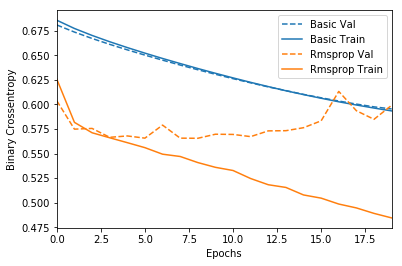

In [7]:
#[RMSprop optimizer]
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import optimizers

# 각각 리뷰에 따른 데이터 길이가 다르기 때문에 데이터의 Shape을 맞춰줘야합니다.
def sequences_shaping(sequences, dimension):
    # 0으로 채워진 (len(sequences), dimension) 크기의 행렬을 만듭니다
    results = np.zeros((len(sequences), dimension))
    for i, word_indices in enumerate(sequences):
        results[i, word_indices] = 1.0  # 각 리뷰 별 빈도수가 높은 단어를 dimension 개수 만큼만 추출하여 사용합니다.
        
    return results

# 시각화 함수
def Visulaize(histories, key='binary_crossentropy'):
    #plt.figure(figsize=(,20))

    for name, history in histories:
        val = plt.plot(history.epoch, history.history['val_'+key],
                   '--', label=name.title()+' Val')
        plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
             label=name.title()+' Train')

    plt.xlabel('Epochs')
    plt.ylabel(key.replace('_',' ').title())
    plt.legend()

    plt.xlim([0,max(history.epoch)])

# 100번째 까지 많이 사용하는 단어까지 추출
word_num = 100
data_num = 25000

# Keras에 내장되어 있는 imdb 데이터 세트를 불러옵니다.
# IMDb 데이터 세트는 Train 25000개 test 25000개로 이루어져 있습니다.
(train_data, train_labels), (test_data, test_labels) = keras.datasets.imdb.load_data(num_words=word_num)

# 데이터 Shape을 맞춰주기 위한 sequence 함수를 불러옵니다.
train_data = sequences_shaping(train_data, dimension=word_num)
test_data = sequences_shaping(test_data, dimension=word_num)

# Optimizer 모델와 비교하기 위해 기본 모델을 하나 만들어줍니다.
basic_model = keras.Sequential([
    # `.summary` 메서드 때문에 `input_shape`가 필요합니다
    # 첫 번째 Layer에 데이터를 넣을때는 input_shape을 맞춰줘야합니다.
    keras.layers.Dense(128, activation=tf.nn.relu, input_shape=(word_num,)),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

# Optimizer를 적용할 모델을 생성합니다.
optimizer_model = keras.Sequential([
    keras.layers.Dense(128, activation=tf.nn.relu, input_shape=(word_num,)),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

# 기존 모델을 학습시킬 최적화 방법, loss 계산 방법, 평가 방법을 설정합니다.
basic_model.compile(optimizer='sgd',
                    loss='binary_crossentropy',
                    metrics=['accuracy', 'binary_crossentropy'])
# 현재 모델이 어떻게 이루어져있는지 출력합니다.
basic_model.summary()
# 모델을 학습시킵니다.
basic_history = basic_model.fit(train_data,train_labels,epochs=20,batch_size=500,validation_data=(test_data, test_labels), verbose=2)

optimizer_model.compile(optimizer=optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0),
                        loss='binary_crossentropy',
                        metrics=['accuracy', 'binary_crossentropy'])
# Optimization 모델이 어떻게 이루어져있는지 출력합니다.
optimizer_model.summary()
# Optimization 모델을 학습시킵니다.
optimizer_history = optimizer_model.fit(train_data, train_labels, epochs=20, batch_size=500, validation_data=(test_data, test_labels),verbose=2)


# 각 모델 별 Loss 그래프를 그려줍니다.
Visulaize([('Basic', basic_history),('RMSprop', optimizer_history)])
              


---
### Adam optimizer

Adam optimizer는 최적화 기법 중 가장 발전된 기법. RMSProp 기법과 모멘텀(momentum)을 함께 사용함으로써, 진행 방향과 step size 모두 적절하게 유지하면서 학습할 수 있도록 고안되었다.

ref) http://shuuki4.github.io/deep%20learning/2016/05/20/Gradient-Descent-Algorithm-Overview.html

---
**Adam optimizer**
  •optimizers.Adam(lr, beta_1, beta_2) :  
  
      •lr : learning rate ( lr >= 0 )
      •beta_1 : momentum을 결정하기 위해 사용되는 파라메터(beta_1 >= 0 )
      •beta_2 : step size를 결정하기 위해 사용되는 파라메터(beta_2 >= 0)
  
  
Refecence : https://keras.io/optimizers/

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_42 (Dense)             (None, 128)               12928     
_________________________________________________________________
dense_43 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_44 (Dense)             (None, 1)                 129       
Total params: 29,569
Trainable params: 29,569
Non-trainable params: 0
_________________________________________________________________
Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 - 2s - loss: 0.6888 - accuracy: 0.5391 - binary_crossentropy: 0.6888 - val_loss: 0.6840 - val_accuracy: 0.5622 - val_binary_crossentropy: 0.6840
Epoch 2/20
25000/25000 - 0s - loss: 0.6814 - accuracy: 0.5682 - binary_crossentropy: 0.6814 - val_loss: 0.6791 - val_accuracy: 0.5798 - val_binary_crossentropy: 

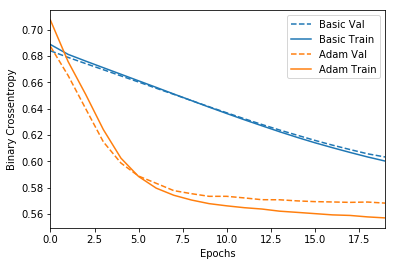

In [8]:
# [Adam optimizer]
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import optimizers

# 각각 리뷰에 따른 데이터 길이가 다르기 때문에 데이터의 Shape을 맞춰줘야합니다.
def sequences_shaping(sequences, dimension):
    # 0으로 채워진 (len(sequences), dimension) 크기의 행렬을 만듭니다
    results = np.zeros((len(sequences), dimension))
    for i, word_indices in enumerate(sequences):
        results[i, word_indices] = 1.0  # 각 리뷰 별 빈도수가 높은 단어를 dimension 개수 만큼만 추출하여 사용합니다.
        
    return results

# 시각화 함수
def Visulaize(histories, key='binary_crossentropy'):
    #plt.figure(figsize=(,20))

    for name, history in histories:
        val = plt.plot(history.epoch, history.history['val_'+key],
                   '--', label=name.title()+' Val')
        plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
             label=name.title()+' Train')

    plt.xlabel('Epochs')
    plt.ylabel(key.replace('_',' ').title())
    plt.legend()

    plt.xlim([0,max(history.epoch)])

# 100번째 까지 많이 사용하는 단어까지 추출
word_num = 100
data_num = 25000

# Keras에 내장되어 있는 imdb 데이터 세트를 불러옵니다.
# IMDb 데이터 세트는 Train 25000개 test 25000개로 이루어져 있습니다.
(train_data, train_labels), (test_data, test_labels) = keras.datasets.imdb.load_data(num_words=word_num)

# 데이터 Shape을 맞춰주기 위한 sequence 함수를 불러옵니다.
train_data = sequences_shaping(train_data, dimension=word_num)
test_data = sequences_shaping(test_data, dimension=word_num)

# Optimizer 모델와 비교하기 위해 기본 모델을 하나 만들어줍니다.
basic_model = keras.Sequential([
    # `.summary` 메서드 때문에 `input_shape`가 필요합니다
    # 첫 번째 Layer에 데이터를 넣을때는 input_shape을 맞춰줘야합니다.
    keras.layers.Dense(128, activation=tf.nn.relu, input_shape=(word_num,)),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

# Optimizer를 적용할 모델을 생성합니다.
optimizer_model = keras.Sequential([
    keras.layers.Dense(128, activation=tf.nn.relu, input_shape=(word_num,)),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

# 기존 모델을 학습시킬 최적화 방법, loss 계산 방법, 평가 방법을 설정합니다.
basic_model.compile(optimizer='sgd',
                    loss='binary_crossentropy',
                    metrics=['accuracy', 'binary_crossentropy'])
# 현재 모델이 어떻게 이루어져있는지 출력합니다.
basic_model.summary()
# 모델을 학습시킵니다.
basic_history = basic_model.fit(train_data,train_labels,epochs=20,batch_size=500,validation_data=(test_data, test_labels), verbose=2)

optimizer_model.compile(optimizer=optimizers.Adam(lr = 0.0001, beta_1 = 0.9, beta_2 = 0.999),
                        loss='binary_crossentropy',
                        metrics=['accuracy', 'binary_crossentropy'])
# Optimization 모델이 어떻게 이루어져있는지 출력합니다.
optimizer_model.summary()
# Optimization 모델을 학습시킵니다.
optimizer_history = optimizer_model.fit(train_data, train_labels, epochs=20, batch_size=500, validation_data=(test_data, test_labels),verbose=2)


# 각 모델 별 Loss 그래프를 그려줍니다.
Visulaize([('Basic', basic_history),('Adam', optimizer_history)])
              